In [1]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [2]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)

## Pre-Processing

In [3]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
train_data = ImageFolder("../data/train", transform=transform_images)
test_data = ImageFolder("../data/test", transform=transform_images)

In [5]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

# S7: Anwendung Transfer-Learning

Nutzung von Batchnorm ohne Regularisierung und mit Stochastic Gradient Descent.


In [118]:
from torchvision import models

In [119]:
resnet101 = models.resnet101(pretrained=True)

In [120]:
# Print model
resnet101.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [121]:
# Freeze model weights
for param in resnet101.parameters():
    param.requires_grad = False

In [122]:
resnet101.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=28))

In [123]:
# Make sure unfreezed classifier layer
for param in resnet101.fc.parameters():
    param.requires_grad = True

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet101.fc.parameters(), lr=0.0001)
dtype = torch.float32
print_total_params(resnet101)

Total Parameters: 42557532


In [125]:
torch.cuda.empty_cache()

In [126]:
resnet50, loss = train_network(model=resnet101, criterion=criterion, optimizer=optimizer, 
                               n_epochs=10, dataloader_train=dataloader_train, 
                               dataloader_test=dataloader_test)

Epoch: 10/10 // Eval-Loop: 19/19: 100%|██████████| 1700/1700 [13:08<00:00,  2.16it/s]      


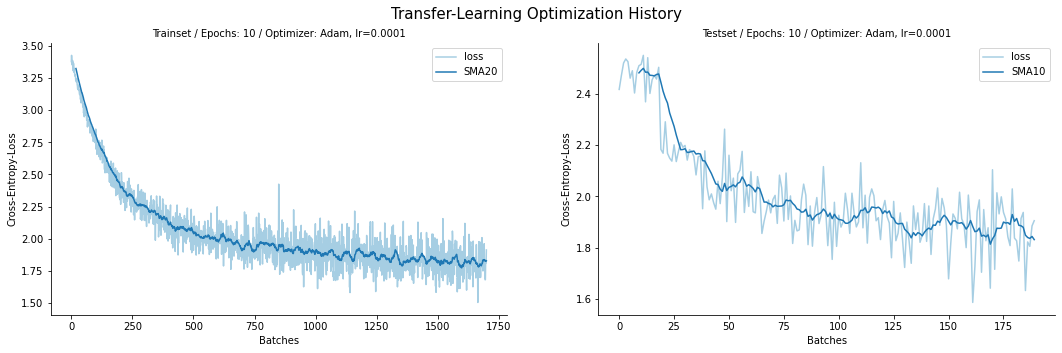

In [158]:
fig = plt.subplots(figsize=(18, 5))

train_sma = 20
test_sma = 10


sns.set_palette('Paired', 2)
plt.subplot(1,2,1)
tmp = pd.Series(loss['train'])
tmpsma = tmp.rolling(train_sma).mean()
p = sns.lineplot(x=tmp.index, y=tmp, label='loss')
p = sns.lineplot(x=tmpsma.index, y=tmpsma, label=f'SMA{train_sma}')
p.set_title('Trainset / Epochs: 10 / Optimizer: Adam, lr=0.0001', fontsize=10)
p.set_ylabel('Cross-Entropy-Loss')
p.set_xlabel('Batches')
sns.despine()

plt.subplot(1,2,2)
tmp = pd.Series(loss['test'])
tmpsma = tmp.rolling(test_sma).mean()
p = sns.lineplot(x=tmp.index, y=tmp, label='loss')
p = sns.lineplot(x=tmpsma.index, y=tmpsma, label=f'SMA{test_sma}')
p.set_title('Testset / Epochs: 10 / Optimizer: Adam, lr=0.0001', fontsize=10)

p.set_ylabel('Cross-Entropy-Loss')
p.set_xlabel('Batches')
sns.despine()


plt.suptitle('Transfer-Learning Optimization History', fontsize=15)
plt.show()

In [163]:
save_model = False

if save_model:
    torch.save(obj=resnet101, f='resnet101')

## Inspect Trained Model

In [6]:
resnet101 = torch.load(f='../resnet101')

In [7]:
y_true, y_pred = network_predict(model=resnet101, dataloader=dataloader_test)

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


In [8]:
accuracy_score(y_true, y_pred)

0.4448360944659852

In [9]:
precision_score(y_true, y_pred, average='macro')

0.427298230564242

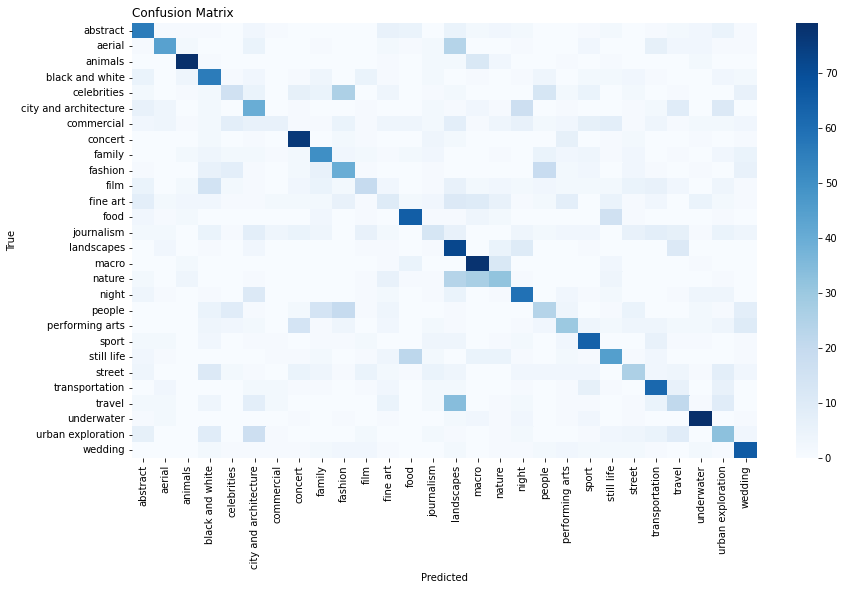

In [11]:
plot_confusion_matrix(y_true, y_pred, train_data)

In [90]:
cl_report_dict = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
cl_report = pd.DataFrame.from_dict(cl_report_dict)
label_translator_ = {str(float(k)):val for k, val in label_translator.items()}
cl_report = cl_report.rename(columns=label_translator_)

cl_report = cl_report.T.reset_index()
cl_report = cl_report.sort_values(by='precision')
cl_report.head(2)

,index,precision,recall,f1-score,support
11,fine art,0.149254,0.099010,0.119048,101.0
13,journalism,0.220339,0.128713,0.162500,101.0


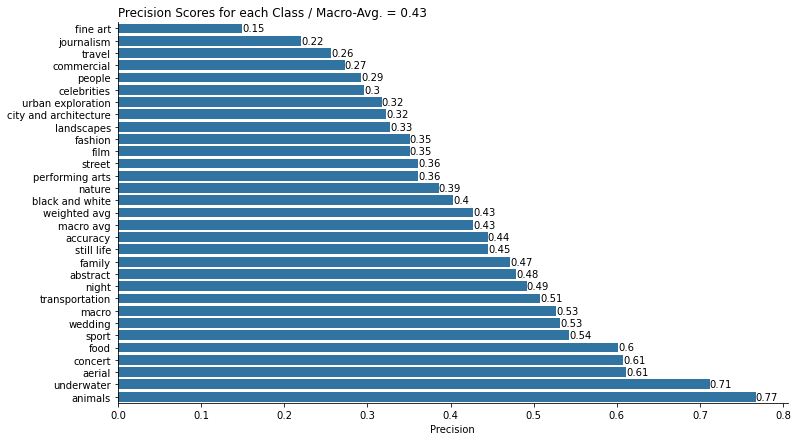

In [97]:
fig = plt.subplots(figsize=(12, 7))
colors = sns.color_palette('Paired', 2)
p = sns.barplot(data=cl_report, y='index', x='precision', 
                color=colors[1])
p.set_ylabel('')
p.set_xlabel('Precision')
p.set_title(f'Precision Scores for each Class / Macro-Avg. = {cl_report["precision"].mean().round(2)}', loc='left')
for i, val in enumerate(cl_report['precision'].to_list()):
    plt.text(x=val, y=i, s=str(round(val, 2)), va='center')
    
sns.despine()

### Inspect wrong predicted Images

In [12]:
def visualize_model(model, dataloader, num_images=6, ncol=3, label_translator=label_translator):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    invTrans = Compose([ Normalize(mean = [ 0., 0., 0. ],
                                   std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                  std = [ 1., 1., 1. ]),
                       ])
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            fig = plt.subplots(figsize=(18, (num_images//ncol) * 5))
            for j in range(num_images):
                plt.subplot(num_images//ncol+1, ncol, j+1)
                plt.title('predicted: {} / actual: {}'.format(label_translator[preds[j].item()],
                                                              label_translator[labels[j].item()]))
                img = inputs.cpu().data[j]
                img = invTrans(img)
                img = to_pil_image(img)
                plt.imshow(img)
                images_so_far += 1

            model.train(mode=was_training)
            plt.subplots_adjust(hspace=.3)
            plt.show()
            break

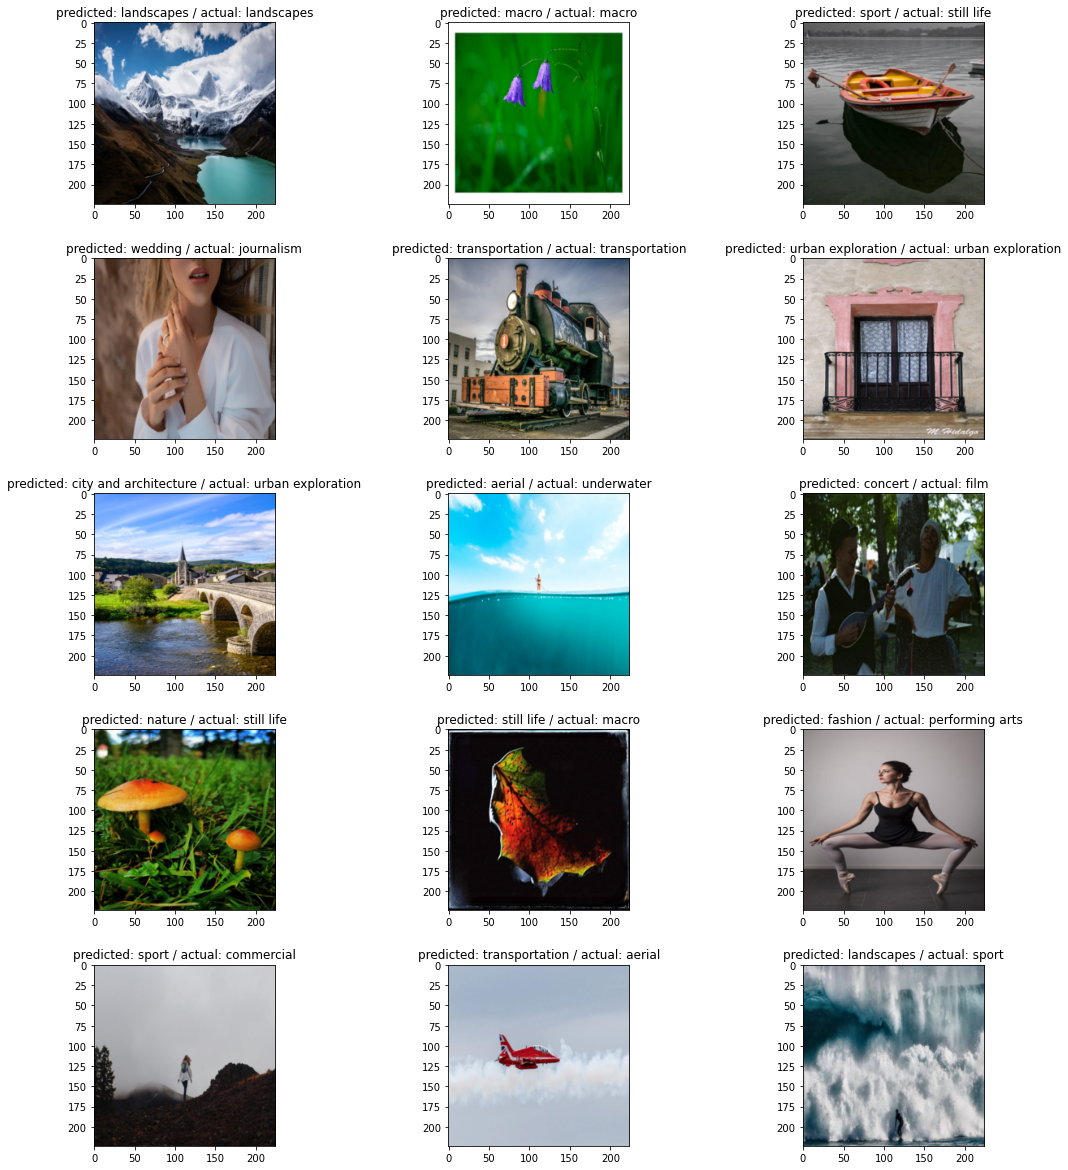

In [13]:
visualize_model(model=resnet101, dataloader=dataloader_test, num_images=15)